<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Run-Settings" data-toc-modified-id="Run-Settings-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Run Settings</a></span></li><li><span><a href="#Display-Configuration" data-toc-modified-id="Display-Configuration-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Display Configuration</a></span></li></ul></li><li><span><a href="#Conference-Call-Extracts-from-fool.com" data-toc-modified-id="Conference-Call-Extracts-from-fool.com-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Conference Call Extracts from fool.com</a></span><ul class="toc-item"><li><span><a href="#read-transcript-extract-from-local" data-toc-modified-id="read-transcript-extract-from-local-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>read transcript extract from local</a></span></li><li><span><a href="#Coverage-and-Descriptives" data-toc-modified-id="Coverage-and-Descriptives-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Coverage and Descriptives</a></span></li></ul></li><li><span><a href="#Universe,-Sectors,-Size,-&amp;-Style-from-ishares.com" data-toc-modified-id="Universe,-Sectors,-Size,-&amp;-Style-from-ishares.com-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Universe, Sectors, Size, &amp; Style from ishares.com</a></span></li><li><span><a href="#Combine,-Filter,-and-Output-Research-Dataset" data-toc-modified-id="Combine,-Filter,-and-Output-Research-Dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Combine, Filter, and Output Research Dataset</a></span><ul class="toc-item"><li><span><a href="#Filter-Conference-Call-Data" data-toc-modified-id="Filter-Conference-Call-Data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Filter Conference Call Data</a></span></li><li><span><a href="#Merge-Meta-Data-from-ishares.com" data-toc-modified-id="Merge-Meta-Data-from-ishares.com-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Merge Meta Data from ishares.com</a></span></li></ul></li><li><span><a href="#Build-Return-Series" data-toc-modified-id="Build-Return-Series-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Build Return Series</a></span></li><li><span><a href="#Write-Research-Data-Extracts-to-File" data-toc-modified-id="Write-Research-Data-Extracts-to-File-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Write Research Data Extracts to File</a></span></li></ul></div>

# RESEARCH DATA COLLECTION & PREPARATION

## Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Markdown as md, Image, HTML
import matplotlib.pyplot as plt
import os
os.chdir('../')
from utils_s3 import get_etf_holdings

### Run Settings

In [2]:
rebuild_transcript_extract = False
rebuild_returns_extract = False

### Display Configuration

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn') 
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['figure.dpi']
display(HTML("<style>.container { width:60% !important; }</style>"))

## Conference Call Extracts from fool.com
sourced from fool.com, stored in `S3`, pulled from there using `AWS Athena`

[COMPLETE CODE IS ON GITHUB](https://github.com/talsan/foolcalls/blob/master/README.md)

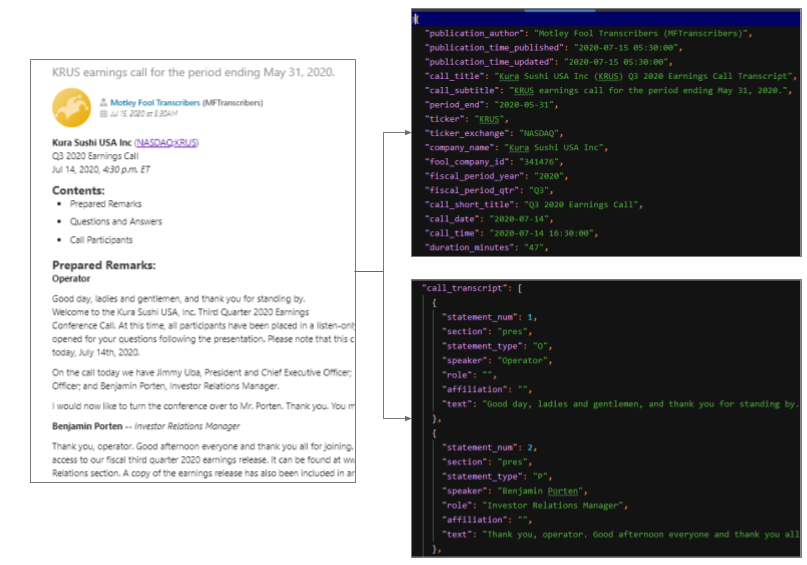

In [4]:
Image(filename='./img/fool.com flow.png')

This was sourced from 

In [5]:
if rebuild_transcript_extract:
    from utils_athena import query

    query_parameters = dict(
        return_df=False, # return a pandas data frame? (if False: returns s3 key)
        download_path='./extracts/foolcalls_extract_20201001.csv', # where to save locally (if None: no local download)
        output_bucket='fool-calls-athena-output', # bucket for query output (bucket needs to exist)
        work_group='qc'
    )

    s3_output_location = query(sql_string='SELECT '
                                          'idx.cid as cid,'
                                          'call_url,ticker,company_name,'
                                          'publication_time_published,publication_time_updated,period_end,'
                                          'fiscal_period_year,fiscal_period_qtr,call_date,duration_minutes,'
                                          'statement_num,section,statement_type,role,text'
                                          ' FROM fool_call_index idx '
                                          'JOIN fool_call_statements st '
                                          'ON idx.cid = st.cid ',
                                          # 'where ticker = \'AAPL\'',
                               **query_parameters)


### read transcript extract from local

In [6]:
calls_raw = pd.read_csv('./extracts/foolcalls_extract_20201001.csv').sort_values(['cid', 'statement_num'])

### Coverage and Descriptives

In [7]:
# get r1000 ETF
r1000 = get_etf_holdings('IWB', '2020-07-31').sort_values('weight', ascending=False)

# only calls from 2020
call_cov = calls_raw.loc[calls_raw['call_date'] >= '2020-01-01', :]
call_cov = call_cov.sort_values(by='call_date',ascending=False).groupby('ticker').head(1)
call_cov = r1000.merge(call_cov, on='ticker', how='inner')

In [8]:
md(f'## <span style="color:orange;font-size:1.75em;">{round(100*call_cov.shape[0]/r1000.shape[0],2)}% </span> \
of R1000 (etf) constituents <br> have at least one conference call from 2020')

## <span style="color:orange;font-size:1.75em;">91.07% </span> of R1000 (etf) constituents <br> have at least one conference call from 2020

<AxesSubplot:xlabel='yyyy-mm'>

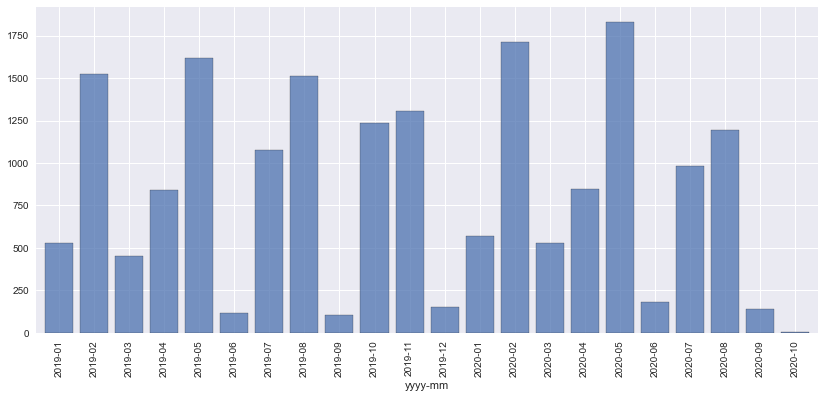

In [9]:
call_info = calls_raw.sort_values(by='call_date').groupby('cid').head(1)
call_info['yyyy-mm'] = call_info['call_date'].str[0:7]
call_info = call_info.loc[call_info['yyyy-mm']>='2019-01',:].dropna(subset=['yyyy-mm'])
call_info.groupby('yyyy-mm')['yyyy-mm'].count().plot(kind='bar',width=0.8, alpha=0.75, edgecolor='black')

## Universe, Sectors, Size, & Style from ishares.com

sourced from ishares.com, stored in S3, pulled from there using boto3.get_object

[COMPLETE CODE IS ON GITHUB](https://github.com/talsan/ishares/blob/master/README.md)

In [10]:
from utils_s3 import get_etf_holdings

r1000 = get_etf_holdings('IWV', '2020-07-31').sort_values('weight', ascending=False)
r1000V = get_etf_holdings('IWD', '2020-07-31').sort_values('weight', ascending=False)
r1000G = get_etf_holdings('IWF', '2020-07-31').sort_values('weight', ascending=False)
r1000[['asofdate','ticker','name','sector','weight','cusip','isin','sedol','price']].head()

,asofdate,ticker,name,sector,weight,cusip,isin,sedol,price
0,2020-07-31,AAPL,APPLE INC,Information Technology,0.0538,037833100,US0378331005,2046251,425.04
1,2020-07-31,MSFT,MICROSOFT CORP,Information Technology,0.0475,594918104,US5949181045,2588173,205.01
2,2020-07-31,AMZN,AMAZON COM INC,Consumer Discretionary,0.0415,023135106,US0231351067,2000019,3164.68
3,2020-07-31,FB,FACEBOOK CLASS A INC,Communication,0.0189,30303M102,US30303M1027,B7TL820,253.67
4,2020-07-31,GOOGL,ALPHABET INC CLASS A,Communication,0.0138,02079K305,US02079K3059,BYVY8G0,1487.95


In [11]:
r1000V[['asofdate','ticker','name','sector','weight','cusip','isin','sedol','price']].head()

,asofdate,ticker,name,sector,weight,cusip,isin,sedol,price
0,2020-07-31,BRKB,BERKSHIRE HATHAWAY INC CLASS B,Financials,0.026000000000000002,084670702,US0846707026,2073390,195.78
1,2020-07-31,JNJ,JOHNSON & JOHNSON,Health Care,0.0227,478160104,US4781601046,2475833,145.76
2,2020-07-31,JPM,JPMORGAN CHASE & CO,Financials,0.0199,46625H100,US46625H1005,2190385,96.64
3,2020-07-31,VZ,VERIZON COMMUNICATIONS INC,Communication,0.016200000000000003,92343V104,US92343V1044,2090571,57.48
4,2020-07-31,PFE,PFIZER INC,Health Care,0.0146,717081103,US7170811035,2684703,38.48


In [12]:
r1000G[['asofdate','ticker','name','sector','weight','cusip','isin','sedol','price']].head()

,asofdate,ticker,name,sector,weight,cusip,isin,sedol,price
0,2020-07-31,AAPL,APPLE INC,Information Technology,0.1103,037833100,US0378331005,2046251,425.04
1,2020-07-31,MSFT,MICROSOFT CORP,Information Technology,0.0974,594918104,US5949181045,2588173,205.01
2,2020-07-31,AMZN,AMAZON COM INC,Consumer Discretionary,0.0851,023135106,US0231351067,2000019,3164.68
3,2020-07-31,FB,FACEBOOK CLASS A INC,Communication,0.038599999999999995,30303M102,US30303M1027,B7TL820,253.67
4,2020-07-31,GOOGL,ALPHABET INC CLASS A,Communication,0.022000000000000002,02079K305,US02079K3059,BYVY8G0,1487.95


## Combine, Filter, and Output Research Dataset

Output: Call Text, alongside Meta-data with Returns (lagged and forward), Sectors, V/G Style

### Filter Conference Call Data

In [13]:
# only calls from 2019/2020
calls_recent = calls_raw.loc[calls_raw['fiscal_period_year'].isin([2019, 2020]), :]

# remove statement_types that are either unknown or operator (i.e. keeping P, Q, A)
calls_recent_PQA = calls_recent.loc[calls_raw['statement_type'].isin(['P', 'Q', 'A'])]

# only top 500 names from r1000
r500 = r1000.sort_values(by='weight',ascending=False).head(500)
calls_recent_PQA_R500 = calls_recent_PQA.merge(r500[['ticker','name','sector','weight']], on='ticker', how='inner')

# remove rows with missing text (nan)
calls_recent_PQA_R500 = calls_recent_PQA_R500.dropna(subset=['text'])

# order it in a way that's easier to look at
calls_recent_PQA_R500 = calls_recent_PQA_R500.sort_values(['cid', 'statement_num']).reset_index(drop=True)
#calls_recent_PQA_R500_text = calls_recent_PQA_R500[['cid','statement_num','text']]
calls_recent_PQA_R500.to_csv('./output/r500_call_text.csv',index=False)

### Merge Meta Data from ishares.com

Meta data is just the raw text data (above) w/o all the statements and text. 

In [14]:
call_meta = calls_recent_PQA_R500.sort_values(by='call_date').groupby('cid').head(1)
call_meta.drop(columns=['statement_num','text'],inplace=True)

Assign "Value" vs "Growth" labels based on index constituency

In [15]:
call_meta['style'] = 'Value'
call_meta.loc[call_meta['ticker'].isin(r1000G['ticker']), 'style'] = 'Growth'
call_meta.loc[call_meta['ticker'].isin(r1000V['ticker']), 'style'] = 'Value'

## Build Return Series
[COMPLETE CODE IS ON GITHUB](https://github.com/talsan/alphavantage/blob/master/README.md)

In [16]:
if rebuild_returns_extract:
    from utils_athena import query

    query_parameters = dict(
        return_df=False,  # return a pandas data frame? (if False: returns s3 key)
        download_path='./extracts/returns_extract_rundate_20200930.csv',  # where to save locally (if None: no local download)
        output_bucket='fool-calls-athena-output',  # bucket for query output (bucket needs to exist)
        work_group='qc'
    )

    s3_output_location = query(sql_string='SELECT * '
                                          'FROM av_prices ' 
                                          'WHERE rundate = date(\'2020-09-30\' )'
                                          'AND ticker IN '
                                          '(SELECT DISTINCT ticker '
                                          'FROM ishares_holdings '
                                          'WHERE etf = \'IWB\')', ** query_parameters)

In [17]:
ret_extract_loc = './extracts/returns_extract_rundate_20200930.csv'

# trading days to calculate on
ret_windows = [5, 21, 63, 127, 255]

# get daily returns and build cumulative index
rets = pd.read_csv(ret_extract_loc)
rets =  rets.loc[(rets['asofdate']>='2015-01-01') & \
                 (rets['ticker'].isin(call_meta['ticker'].unique())),:]
rets.loc[rets['return'] > 1, 'return'] = 1

rets['adj_pct_chg'] = rets.sort_values(by=['ticker','asofdate']).groupby('ticker')['adjusted_close'].pct_change(1)
rets['cml_ret'] = rets.groupby('ticker')['adj_pct_chg'].transform(lambda x: (1 + x).cumprod())
rets.reset_index(drop=True, inplace=True)

In [18]:
rets[['ticker','asofdate','close','adjusted_close','return','adj_pct_chg']]

,ticker,asofdate,close,adjusted_close,return,adj_pct_chg
0,BKI,2015-05-20,27.11,27.11,NaN,NaN
1,BKI,2015-05-21,27.73,27.73,0.022870,0.022870
2,BKI,2015-05-22,28.36,28.36,0.022719,0.022719
3,BKI,2015-05-26,27.99,27.99,-0.013047,-0.013047
4,BKI,2015-05-27,28.00,28.00,0.000357,0.000357
...,...,...,...,...,...,...
673133,USB,2020-10-05,37.73,37.73,0.026108,0.026108
673134,USB,2020-10-06,37.42,37.42,-0.008216,-0.008216
673135,USB,2020-10-07,38.79,38.79,0.036611,0.036611
673136,USB,2020-10-08,39.50,39.50,0.018304,0.018304


Define function that creates lagged/forward returns across custom set of horizons

In [19]:
def _explode_returns(id_rets,ret_windows):
       
    id_rets = id_rets.sort_values(by='asofdate',ascending=False)
    for rw in reversed(ret_windows): # for each prior horizon
        id_rets[f't-{rw} trading days'] = id_rets['adjusted_close'].pct_change(-rw)    
        
    id_rets = id_rets.sort_values(by='asofdate',ascending=True)
    for rw in ret_windows: # for each fwd horizon
        id_rets[f't+{rw} trading days'] = id_rets['adjusted_close'].pct_change(rw).shift(-rw)        
    
    return id_rets

Calc lead/lag raw returns per security

In [20]:
all_rets = rets.groupby('ticker').apply(lambda x: _explode_returns(x,ret_windows)).reset_index(drop=True)
call_rets = all_rets.merge(call_meta[['cid','ticker','call_date']],how='inner',left_on=['ticker','asofdate'],right_on=['ticker','call_date'])

In [21]:
all_rets.describe()

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,divyld,return,adj_pct_chg,cml_ret,t-255 trading days,t-127 trading days,t-63 trading days,t-21 trading days,t-5 trading days,t+5 trading days,t+21 trading days,t+63 trading days,t+127 trading days,t+255 trading days
count,673138.000000,673138.000000,673138.000000,673138.000000,673138.000000,6.731380e+05,673138.000000,673138.000000,673098.000000,673098.000000,672658.000000,672658.000000,550738.000000,612178.000000,642898.000000,663058.000000,670738.000000,670738.000000,663058.000000,642898.000000,612178.000000,550738.000000
mean,116.064229,117.360009,114.740126,116.096569,109.040446,4.146475e+06,0.006497,1.000084,0.000080,0.000846,0.000766,1.605768,0.183028,0.085010,0.044726,0.015306,0.003765,0.003765,0.015306,0.044726,0.085010,0.183028
std,154.215541,155.884779,152.493384,154.241771,152.514782,8.855501e+06,0.190894,0.014029,0.002314,0.021143,0.021011,1.183662,0.345199,0.227912,0.157585,0.091178,0.045750,0.045750,0.091178,0.157585,0.227912,0.345199
min,1.620000,1.690000,1.610000,1.620000,1.620000,0.000000e+00,0.000000,0.333300,0.000000,-0.548530,-0.548530,0.130569,-0.858322,-0.824609,-0.808541,-0.800234,-0.626171,-0.626171,-0.800234,-0.808541,-0.824609,-0.858322
25%,50.000000,50.570000,49.420000,50.000000,44.370000,8.643625e+05,0.000000,1.000000,0.000000,-0.007540,-0.007596,1.040700,-0.010838,-0.042338,-0.039428,-0.029274,-0.015827,-0.015827,-0.029274,-0.039428,-0.042338,-0.010838
50%,79.470000,80.290000,78.612950,79.500000,72.148250,1.762680e+06,0.000000,1.000000,0.000000,0.001005,0.000949,1.293489,0.147712,0.070388,0.041906,0.015284,0.004174,0.004174,0.015284,0.041906,0.070388,0.147712
75%,130.000000,131.440000,128.510000,130.030000,122.279550,3.955838e+06,0.000000,1.000000,0.000000,0.009501,0.009413,1.787435,0.319130,0.185609,0.119125,0.058572,0.023807,0.023807,0.058572,0.119125,0.185609,0.319130
max,3547.000000,3552.250000,3486.685000,3531.450000,3531.450000,4.313150e+08,103.750000,7.000000,0.893757,0.897529,0.738544,34.267658,10.638640,11.333759,7.531037,3.291241,1.341837,1.341837,3.291241,7.531037,11.333759,10.638640


In [22]:
#all_rets.loc[:,['ticker','asofdate'] + all_rets.columns[all_rets.columns.str.contains('trading')]].head()
all_rets.loc[all_rets['cml_ret']>10,]
all_rets.loc[all_rets['ticker']=='W',:].reset_index().tail(100)
#all_rets.loc[(all_rets['ticker']=='W') & (all_rets['asofdate']=='2019-01-29'),
#             ['ticker','asofdate'] + list(all_rets.columns[all_rets.columns.str.contains('trading')])]

,index,ticker,download_timestamp,asofdate,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,divyld,return,rundate,adj_pct_chg,cml_ret,t-255 trading days,t-127 trading days,t-63 trading days,t-21 trading days,t-5 trading days,t+5 trading days,t+21 trading days,t+63 trading days,t+127 trading days,t+255 trading days
1354,632325,W,2020-10-11 12:13:08.000,2020-05-20,167.930,168.2350,154.5200,162.67,162.67,2973807.0,0.0,1.0,0.0,0.007931,2020-09-30,0.007931,7.828200,0.097194,0.943256,0.975829,0.697308,-0.113901,-0.002275,0.290896,1.047151,NaN,NaN
1355,632326,W,2020-10-11 12:13:08.000,2020-05-21,162.670,164.9489,156.4200,163.50,163.50,1859177.0,0.0,1.0,0.0,0.005102,2020-09-30,0.005102,7.868142,0.087101,0.891048,1.040180,0.696586,-0.054585,0.049235,0.272538,1.011988,NaN,NaN
1356,632327,W,2020-10-11 12:13:08.000,2020-05-22,162.530,166.3800,160.4200,165.69,165.69,1590645.0,0.0,1.0,0.0,0.013394,2020-09-30,0.013394,7.973532,0.084785,0.974851,1.193407,0.583580,-0.042808,0.008631,0.252520,1.056008,NaN,NaN
1357,632328,W,2020-10-11 12:13:08.000,2020-05-26,167.350,168.5900,157.7900,158.08,158.08,2487569.0,0.0,1.0,0.0,-0.045929,2020-09-30,-0.045929,7.607315,0.038088,0.915657,1.206281,0.291398,0.027561,0.193257,0.269674,1.138158,NaN,NaN
1358,632329,W,2020-10-11 12:13:08.000,2020-05-27,156.710,157.5000,144.5100,153.89,153.89,3083560.0,0.0,1.0,0.0,-0.026506,2020-09-30,-0.026506,7.405679,0.017791,0.869412,1.162895,0.194705,-0.046471,0.180129,0.332900,1.196764,NaN,NaN
1359,632330,W,2020-10-11 12:13:08.000,2020-05-28,154.140,166.4600,150.5700,162.30,162.30,2559867.0,0.0,1.0,0.0,0.054649,2020-09-30,0.054649,7.810395,0.135759,0.915949,1.307036,0.312257,-0.002275,0.094023,0.244239,1.109673,NaN,NaN
1360,632331,W,2020-10-11 12:13:08.000,2020-05-29,165.070,177.2800,163.6150,171.55,171.55,3667849.0,0.0,1.0,0.0,0.056993,2020-09-30,0.056993,8.255534,0.197975,1.012789,1.713969,0.320225,0.049235,-0.004605,0.167182,0.931157,NaN,NaN
1361,632332,W,2020-10-11 12:13:08.000,2020-06-01,172.680,176.1700,165.5600,167.12,167.12,1910976.0,0.0,1.0,0.0,-0.025823,2020-09-30,-0.025823,8.042348,0.154702,0.934035,1.705520,0.347307,0.008631,0.053076,0.182444,0.860579,NaN,NaN
1362,632333,W,2020-10-11 12:13:08.000,2020-06-02,175.000,190.6198,174.5000,188.63,188.63,4493944.0,0.0,1.0,0.0,0.128710,2020-09-30,0.128710,9.077478,0.332509,1.167165,2.032637,0.539837,0.193257,-0.085882,0.162010,0.572178,NaN,NaN
1363,632334,W,2020-10-11 12:13:08.000,2020-06-03,185.440,189.9900,178.6850,181.61,181.61,2343002.0,0.0,1.0,0.0,-0.037216,2020-09-30,-0.037216,8.739654,0.256817,1.138601,1.961194,0.354187,0.180129,0.004240,0.178900,0.689499,NaN,NaN


calc universe lead/lag returns

In [23]:
univ_rets = rets.sort_values(by='asofdate').groupby('asofdate')['adj_pct_chg'].median().reset_index()
univ_rets['adjusted_close'] = univ_rets['adj_pct_chg'].transform(lambda x: (1 + x).cumprod())
univ_rets = _explode_returns(univ_rets,ret_windows)
univ_rets = univ_rets.melt(id_vars=['asofdate','adj_pct_chg'],
    value_vars=univ_rets.columns[univ_rets.columns.str.contains('trading days')])

calc sector lead/lag returns

In [24]:
rets_w_sector = rets.merge(r1000[['ticker','sector']],how='inner',on='ticker')
sector_rets = rets_w_sector.sort_values(by='asofdate').groupby(['asofdate','sector'])['adj_pct_chg'].median().reset_index()
sector_rets['adjusted_close'] = sector_rets['adj_pct_chg'].transform(lambda x: (1 + x).cumprod())
sector_rets = _explode_returns(sector_rets,ret_windows)
sector_rets = sector_rets.melt(id_vars=['asofdate','sector','adj_pct_chg'],
    value_vars=sector_rets.columns[sector_rets.columns.str.contains('trading days')])

merge asset returns + universe returns + sector returns

In [25]:
# merge univ returns
call_rets_m = call_rets.melt(id_vars=['cid','ticker','asofdate'],
                           value_vars=call_rets.columns[call_rets.columns.str.contains('trading days')])
act_rets = call_rets_m.merge(right=univ_rets,how='inner',on=['asofdate','variable'],suffixes=('_sec','_univ'))

# merge sector returns
act_rets = act_rets.merge(r1000[['ticker','sector']],how='inner',on='ticker')


calc active lead/lag returns (vs univ and sector)

In [26]:
act_rets = act_rets.merge(right=sector_rets,how='inner',on=['asofdate','variable','sector'])

act_rets['act_ret_univ'] = act_rets['value_sec'] - act_rets['value_univ']
act_rets['act_ret_sector'] = act_rets['value_sec'] - act_rets['value']

act_rets_univ = act_rets[['cid','ticker','asofdate','variable','act_ret_univ']]
act_rets_univ = act_rets_univ.pivot(index=['cid','ticker','asofdate'],columns='variable',values='act_ret_univ').reset_index()

act_rets_sector = act_rets[['cid','ticker','asofdate','variable','sector','act_ret_sector']]
act_rets_sector = act_rets_sector.pivot(index=['cid','ticker','asofdate','sector'],columns='variable',values='act_ret_sector').reset_index()

In [27]:
act_rets_sector.loc[(act_rets_sector['ticker']=='AAPL') & (act_rets_sector['asofdate']>'2018-01-01'),:].head()

variable,cid,ticker,asofdate,sector,t+127 trading days,t+21 trading days,t+255 trading days,t+5 trading days,t+63 trading days,t-127 trading days,t-21 trading days,t-255 trading days,t-5 trading days,t-63 trading days
102,2019-01-29-apple-inc-aapl-q1-2019-earnings-con...,AAPL,2019-01-29,Information Technology,-0.216542,-0.069378,0.108749,0.126800,-0.115107,-0.607251,-0.028123,-2.707751,0.037123,-0.365231
358,2019-04-30-apple-inc-aapl-q2-2019-earnings-cal...,AAPL,2019-04-30,Information Technology,0.388699,-0.020397,0.828482,0.041039,0.191879,-0.192033,0.021427,-0.351697,-0.050092,0.179660
791,2019-07-30-apple-inc-aapl-q3-2019-earnings-cal...,AAPL,2019-07-30,Information Technology,0.979746,0.144882,1.294599,-0.051149,0.556327,0.304385,0.060380,-0.227602,0.005107,-0.077232
1246,2019-10-30-apple-inc-aapl-q4-2019-earnings-cal...,AAPL,2019-10-30,Information Technology,0.029756,0.024554,NaN,0.046080,0.160786,-0.069566,0.086875,-0.023037,-0.020301,0.078792
1563,2020-01-28-apple-inc-aapl-q1-2020-earnings-cal...,AAPL,2020-01-28,Information Technology,-0.112695,-0.149488,NaN,0.019834,-0.289584,0.445375,0.163649,0.911462,0.000941,0.446585


## Write Research Data Extracts to File

In [28]:
call_meta_ret_univ = call_meta.merge(act_rets_univ.drop(columns=['ticker','asofdate']),how='left',on='cid')
call_meta_ret_univ.to_csv('./output/r500_call_meta_univ.csv',index=False)

call_meta_ret_sector = call_meta.merge(act_rets_sector.drop(columns=['ticker','asofdate']),how='left',on='cid')
call_meta_ret_sector.to_csv('./output/r500_call_meta_sector.csv',index=False)